# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

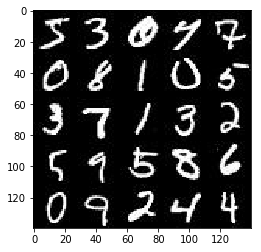

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

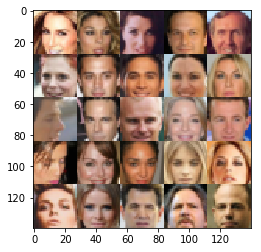

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="input_z")

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.15
    padding = 'same'
    with tf.variable_scope('discriminator', reuse=reuse):        
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding=padding)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, padding=padding)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, padding=padding)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        flat   = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dropout(tf.layers.dense(flat, 1), rate=0.1)
        
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.15
    same='same'
    
    rdi = tf.random_normal_initializer(stddev=0.01)
    
    with tf.variable_scope('generator', reuse=not(is_train)):        
        h1 = tf.layers.dense(z, 7*7*256)
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 =tf.maximum(alpha * h1, h1) #leaky_relu
    
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=2, kernel_initializer=rdi, padding=same)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2) #leaky_relu
    
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, strides=2, kernel_initializer=rdi, padding=same)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3) #leaky_relu
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 3, strides=1, kernel_initializer=rdi, padding=same)
        output = tf.tanh(logits)
 
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function      
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        
        # Get the trainable_variables, split into G and D parts
        t_vars = tf.trainable_variables()
        g_vars = []
        d_vars = []
        for var in t_vars:
            if(var.name.startswith('generator')):
                g_vars.append(var)
            elif var.name.startswith('discriminator'):
                d_vars.append(var)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)       
        d_updates = []
        g_updates = []        
        for opt in update_ops:
            if opt.name.startswith('generator'):
                g_updates.append(opt)
            elif opt.name.startswith('discriminator'):
                d_updates.append(opt)            
                
        with tf.control_dependencies(g_updates):
            d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        with tf.control_dependencies(g_updates):
            g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt            


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

__Hyper Parameters__

In [31]:
steps = 100
print_every = 10
show_every = 100
losses = []
n_images = 25

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model                
    img_width    = data_shape[1]
    img_height   = data_shape[2]
    img_channels = data_shape[3]
        
    #Input
    input_real, input_z, tf_placeholder_learning_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    #Loss
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    
    #Optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
      
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps = steps + 1
                
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # Run optimizers               
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)                                                                   

Epoch 1/2... Discriminator Loss: 3.0841... Generator Loss: 11.0125
Epoch 1/2... Discriminator Loss: 1.9188... Generator Loss: 3.9594
Epoch 1/2... Discriminator Loss: 2.1482... Generator Loss: 0.2444
Epoch 1/2... Discriminator Loss: 1.7649... Generator Loss: 0.2918
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.3080
Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 0.3490
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.3076
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 1.3630


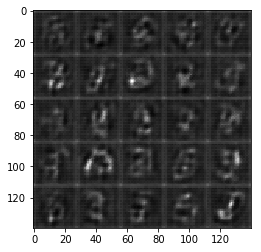

Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 1.3168... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 1.5974
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.9632
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 1.4490
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.8489... Generator Loss: 0.2316


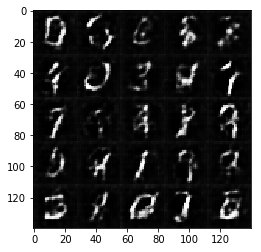

Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.4743
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.2242
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.3570
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.3042... Generator Loss: 0.5074


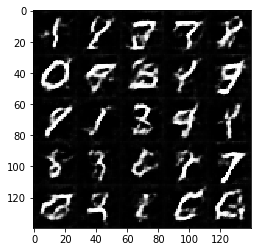

Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.4374
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.7055... Generator Loss: 0.2746
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.8601
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.4557
Epoch 1/2... Discriminator Loss: 1.4704... Generator Loss: 0.3555


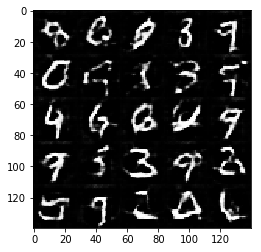

Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 1.1720
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.5106
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.4435
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.5764


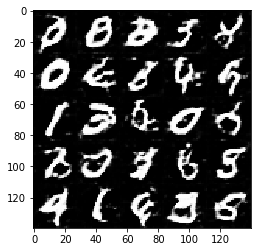

Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.6561... Generator Loss: 0.2968
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.4440
Epoch 2/2... Discriminator Loss: 1.7532... Generator Loss: 0.2459
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 1.0845
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 1.2878
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.4693


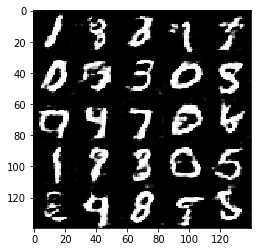

Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.5221
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.4542... Generator Loss: 0.3829
Epoch 2/2... Discriminator Loss: 1.8892... Generator Loss: 0.2619
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.6720... Generator Loss: 0.2752
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 1.1031
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.5267


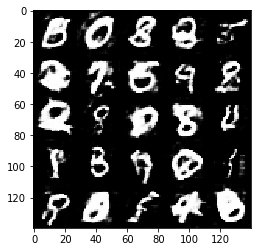

Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 1.4281
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 2.1629... Generator Loss: 0.2381
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.5619
Epoch 2/2... Discriminator Loss: 1.7212... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.9443


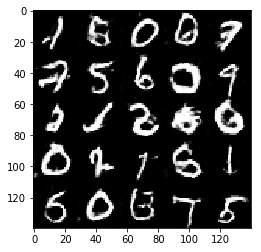

Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 1.1247
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 1.0675
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 1.0504
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 1.1551
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 1.6017
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.7604... Generator Loss: 1.8272


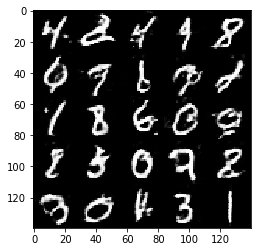

Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 1.0474
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.9098


In [33]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.35

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs,
          batch_size, 
          z_dim,
          learning_rate,
          beta1, 
          mnist_dataset.get_batches,
          mnist_dataset.shape,
          mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 4.7096... Generator Loss: 0.0532
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 2.4797... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 1.7677... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.8376... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 1.5335... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.6831... Generator Loss: 0.4229
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.7371... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.5567


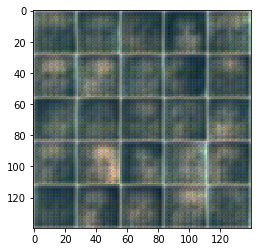

Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.8737
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.5054


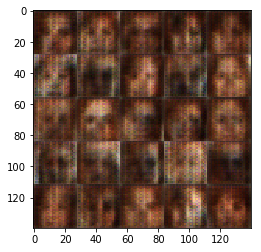

Epoch 1/2... Discriminator Loss: 1.4768... Generator Loss: 0.6870
Epoch 1/2... Discriminator Loss: 1.5710... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 1.6116... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.7937


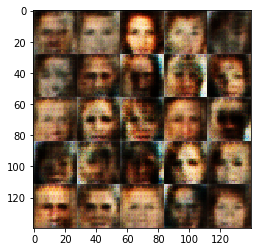

Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.4464... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 1.5825... Generator Loss: 0.6277


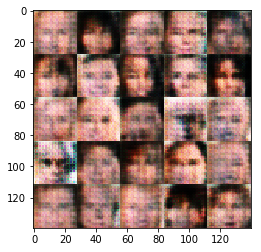

Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.5892
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.5754
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.4407... Generator Loss: 0.6441


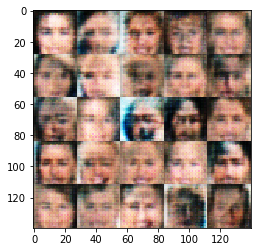

Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.4799... Generator Loss: 0.7953
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6390


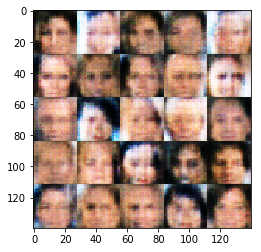

Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 1.5156... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.8465
Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.6577


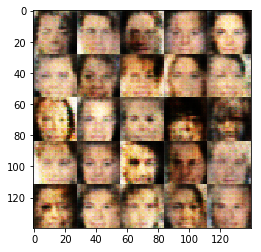

Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.5007
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.7124
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.6454


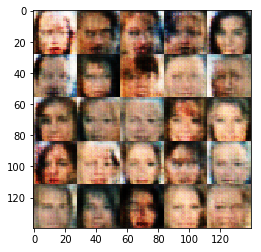

Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.6518
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.6868


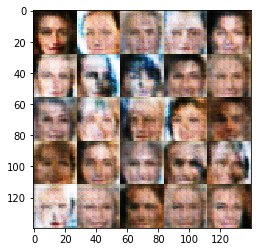

Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.3789... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.4022... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.5984


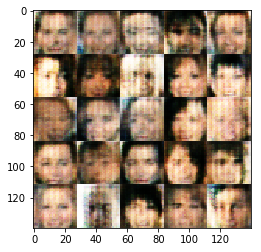

Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.6218... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.7825
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 1.4653... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.7501


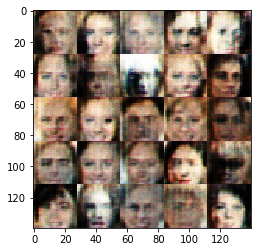

Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.8306


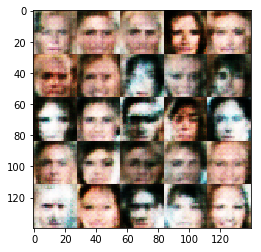

Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5854
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7898
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.6223
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.6442


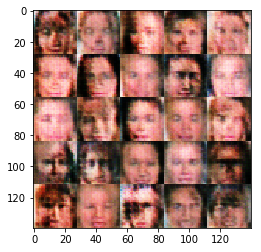

Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.6659
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.6701
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.3668... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.6728


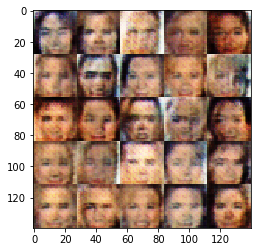

Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.6378


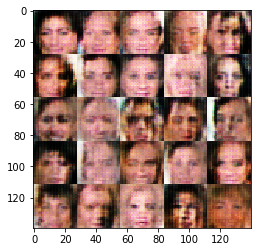

Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.3978... Generator Loss: 0.7261
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 0.7678
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.8781


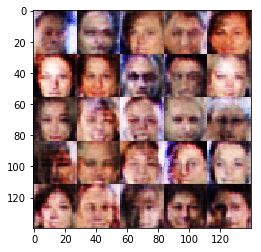

Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.7183


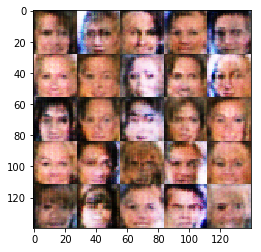

Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.5932


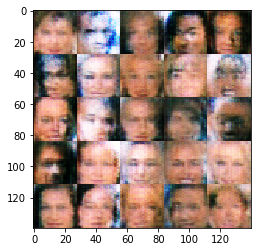

Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.6057


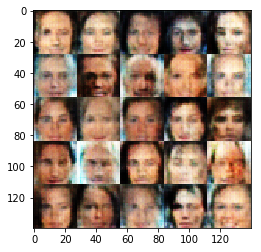

Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.6467
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7047
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.6933


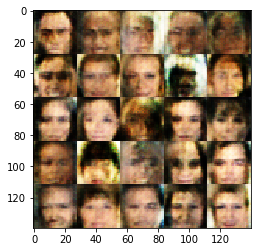

Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.6066
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.5846
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.6407


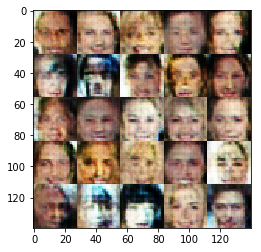

Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.6663


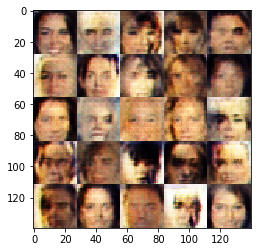

Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.7309


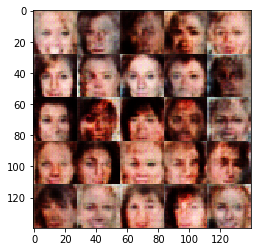

Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.7179


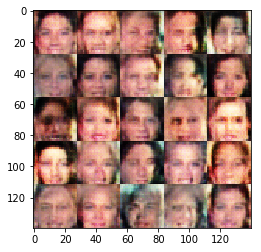

Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.7153
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.5607
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.5110


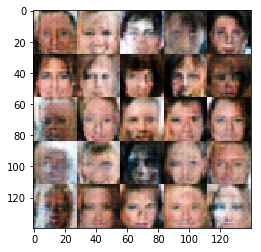

Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6814


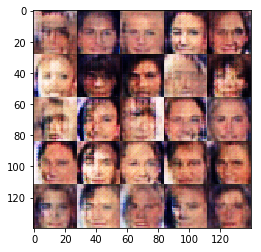

Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.6057
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.7875


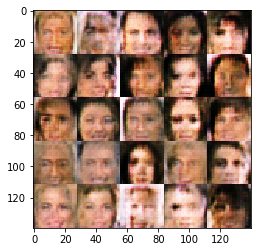

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.6722


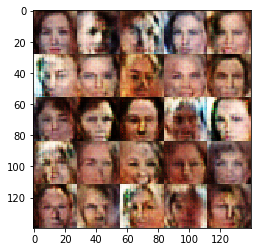

Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.6812


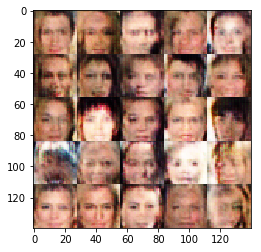

Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.7529
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.7867


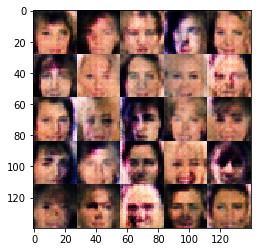

Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.7722
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7604
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.7202
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 1.0171


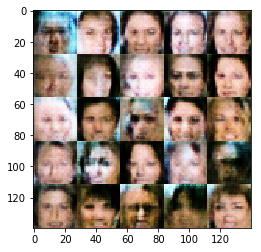

Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.3451... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.6215
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.6381


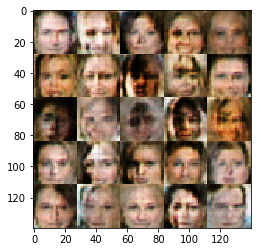

Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.6596
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.5780
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.6405


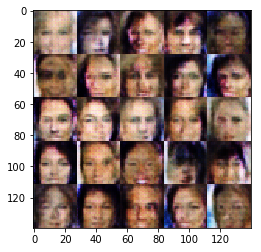

Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.5991
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.7266


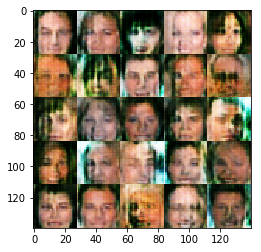

Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.6512
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.6799


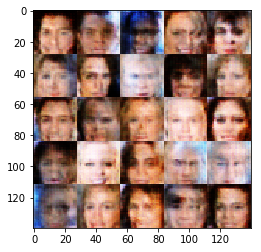

Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.6318
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.6469


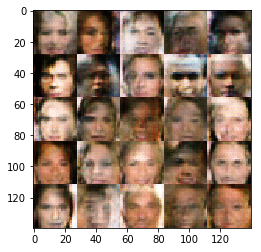

Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.7216
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.5979
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.6433


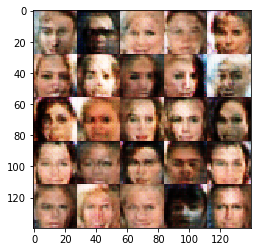

Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.6497
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.6030
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.5294... Generator Loss: 0.6253
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.7830


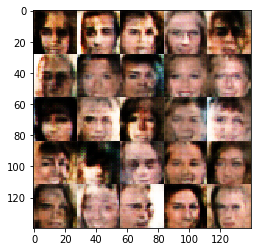

Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.8078


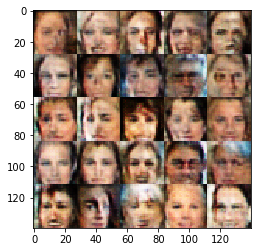

Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.6417


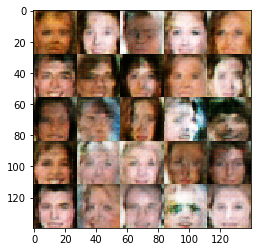

Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.5926
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.6800


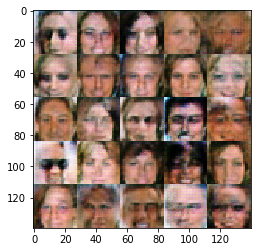

Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.7734
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.7146


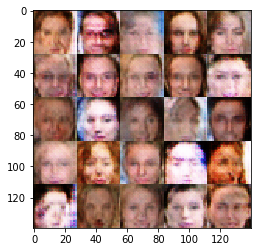

Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.6438
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.7024


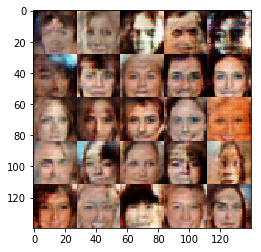

Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.6023
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.7268
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.3808... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.6229


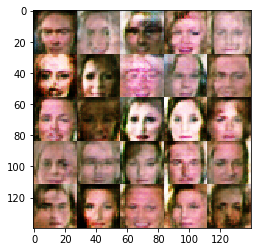

Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.5747


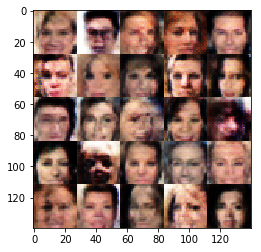

Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.7128
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.7282
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.6245
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.6847


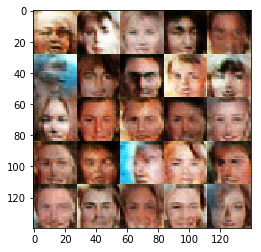

Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 1.3981... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.4430... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.7103


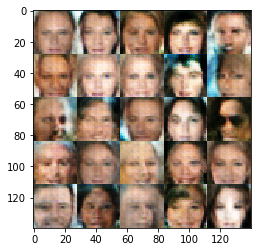

Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7867
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.6789


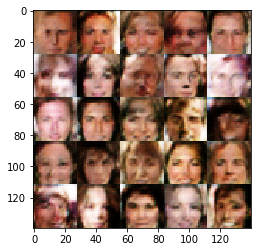

Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.6043
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.5180
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.7037
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7103


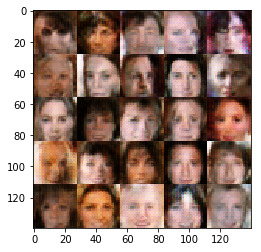

Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.5822
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.7578


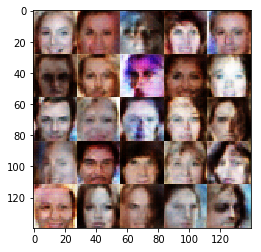

Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.3977... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.3431... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.6415


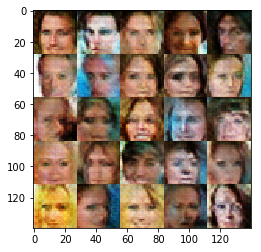

Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.7005
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7560


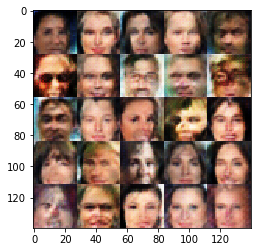

Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.8243


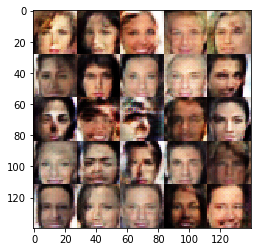

Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8209


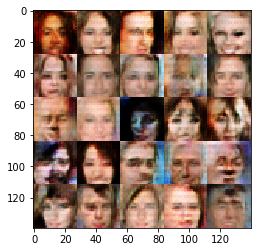

Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.5806
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.6670


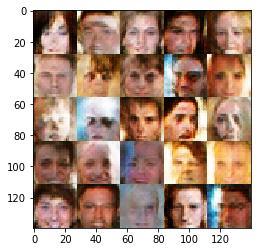

Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.7356
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.6332
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.6441


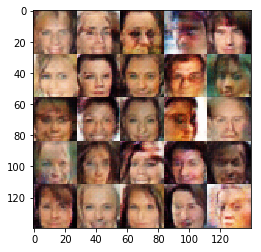

Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.7193
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.6674


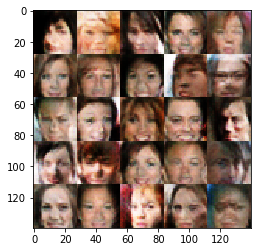

Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.6854


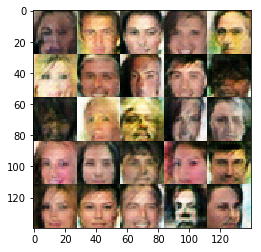

Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.7340
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.7455


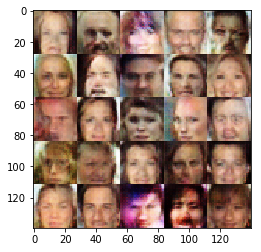

Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.7269


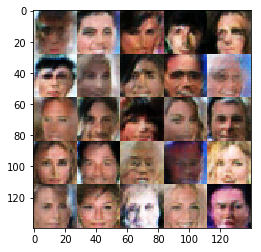

Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.6336
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.6850


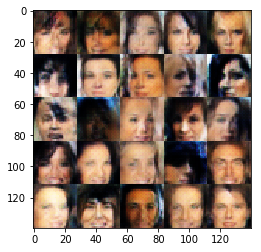

Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.5710
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.6691


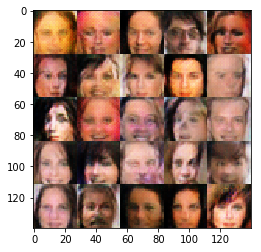

Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.5923


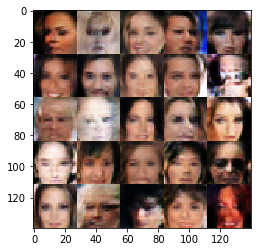

Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.6290


In [21]:
batch_size = 64
z_dim = 64
learning_rate = 0.001
beta1 = 0.35

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.